In [1]:
import pandas as pd
import numpy as np

## read the data

In [2]:
df=pd.read_pickle('data_cleaned_1')

In [4]:
df.head()

,score,text
0,3.0,"[good, helpfull, read, book, good, type, thats..."
1,1.0,"[sadly, overprice, irrelevant, spite, claim, i..."
2,2.0,"[endless, rant, howard, borrow, dennis, miller..."
3,1.0,"[not, quite, hip, really, shame, time, reserch..."
4,5.0,"[journey, centre, earth, hey, great, book, abs..."


## explore the data

In [3]:
import matplotlib.pyplot as plt 

print("Number of rows per star rating:")
print(df['score'].value_counts())

Number of rows per star rating:
5.0    30268
4.0     9691
3.0     4276
1.0     3277
2.0     2488
Name: score, dtype: int64


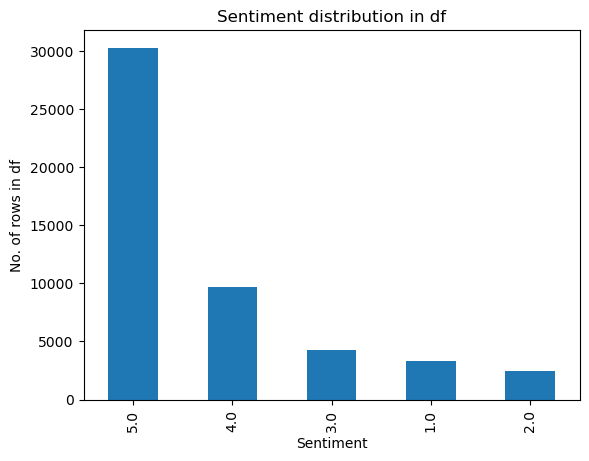

In [6]:
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(df['score']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

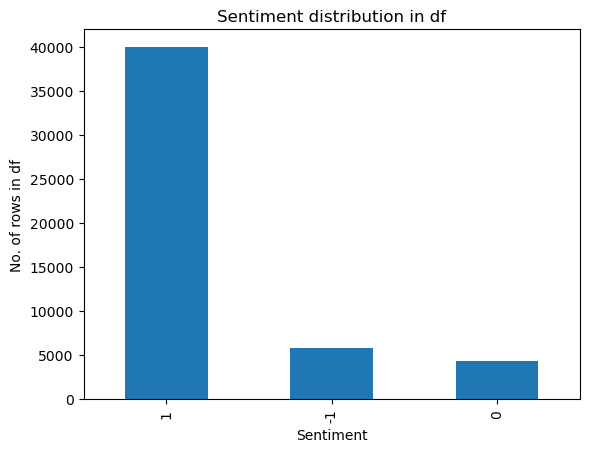

In [5]:
# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1
# Mapping stars to sentiment into three categories
df['sentiment'] = [ map_sentiment(x) for x in df['score']]
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

## Splitting into Train and Test Sets

In [8]:
from sklearn.model_selection import train_test_split
# Train Test Split Function
def split_train_test(df, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df['text'], 
                                                        df['score'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(df)

Value counts for Train sentiments
5.0    21230
4.0     6726
3.0     3000
1.0     2312
2.0     1732
Name: score, dtype: int64
Value counts for Test sentiments
5.0    9038
4.0    2965
3.0    1276
1.0     965
2.0     756
Name: score, dtype: int64
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
   index                                               text
0  36322  [reactionary, defense, status, quo, education,...
1   4638  [realistic, novel, battle, gettysburg, wonderf...
2  46808  [book, well, write, not, sure, train, really, ...
3  38099  [face, resurface, pick, local, library, begin,...
4  31461  [help, train, teacher, yoshinkan, aikido, year...


## construct Doc2vec model 

### construct vector

In [9]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# TaggedDocuments are tuple of stemmed_tokens and class lable, example is printed (scroll to the right to see label)
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['text'])]
print(documents[1])

# Initialize the model
doc2vec_model = Doc2Vec(documents, vector_size=1000, window=3, min_count=1, workers=4)

# Sample vector for the stemmed tokens
vector = doc2vec_model.infer_vector(df['text'][0])
# Printing sample vector
print(len(vector))
print("Top 10 values in Doc2Vec inferred vector:")
print(vector[:10])

TaggedDocument(['sadly', 'overprice', 'irrelevant', 'spite', 'claim', 'illustrate', 'pmo', 'effective', 'reducing', 'cost', 'project', 'decrease', 'time', 'market', 'new', 'product', 'increase', 'corporate', 'profit', 'ensure', 'project', 'success', 'small', 'overprice', 'book', 'actually', 'none', 'thing', 'collection', 'unrelated', 'article', 'write', 'dry', 'overly', 'academic', 'style', 'book', 'totally', 'fail', 'address', 'proposition', 'project', 'management', 'office', 'pmo', 'add', 'value', 'organization', 'many', 'statement', 'effect', 'the', 'pmo', 'perform', 'function', 'assertion', 'function', 'itself', 'whether', 'easily', 'perform', 'organization', 'not', 'formal', 'pmo', 'surprising', 'half', 'eight', 'chapter', 'relationship', 'pmo', 'function', 'all', 'discuss', 'various', 'project', 'management', 'issue', 'interest', 'well', 'cover', 'elsewhere', 'literature', 'topic', 'not', 'one', 'expect', 'purchase', 'book', 'purportedly', 'discuss', 'pmo', 'function', 'the', 'bo

### write to a folder

In [10]:
import time
start_time = time.time()
# Store the vectors for train data in 
OUTPUT_FOLDER='Doc2vec'
doc2vec_filename = OUTPUT_FOLDER + 'train_review_doc2vec.csv'
with open(doc2vec_filename, 'w+') as doc2vec_file:
    for index, row in X_train.iterrows():# go through every row
        model_vector = doc2vec_model.infer_vector(row['text'])
        if index == 0:
            header = ",".join(str(ele) for ele in range(1000))
            doc2vec_file.write(header)
            doc2vec_file.write("\n")
        line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        doc2vec_file.write(line1)
        doc2vec_file.write('\n')
print("Time taken to create doc2vec vectors: " + str(time.time() - start_time))

Time taken to create doc2vec vectors: 92.2918918132782


### train model using decision tree

In [11]:
# Load from the filename
OUTPUT_FOLDER='Doc2vec'
doc2vec_filename = OUTPUT_FOLDER + 'train_review_doc2vec.csv'
doc2vec_df = pd.read_csv(doc2vec_filename)
from sklearn.tree import DecisionTreeClassifier
clf_decision_doc2vec = DecisionTreeClassifier()
# Fit the model
clf_decision_doc2vec.fit(doc2vec_df, Y_train['score'])

DecisionTreeClassifier()

### test model

In [12]:
from sklearn.metrics import classification_report
test_features_doc2vec = []
for index, row in X_test.iterrows():
    model_vector = doc2vec_model.infer_vector(row['text'])
    test_features_doc2vec.append(model_vector)
test_predictions_doc2vec = clf_decision_doc2vec.predict(test_features_doc2vec)
print(classification_report(Y_test['score'],test_predictions_doc2vec))

              precision    recall  f1-score   support

         1.0       0.13      0.15      0.14       965
         2.0       0.10      0.10      0.10       756
         3.0       0.13      0.15      0.14      1276
         4.0       0.23      0.24      0.23      2965
         5.0       0.66      0.63      0.65      9038

    accuracy                           0.45     15000
   macro avg       0.25      0.25      0.25     15000
weighted avg       0.47      0.45      0.46     15000



C:\Users\haile\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [18]:
test_predictions_doc2vec

array([ 1,  1,  0, ..., -1, -1,  1], dtype=int64)

### train model using nuro

In [19]:
max_epochs = 500
vec_size = 100
alpha = 0.025
model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm=1)
  
model.build_vocab(documents)

In [21]:
for epoch in range(max_epochs):
    if epoch % 100 == 0:
        print('iteration {0}'.format(epoch))

    model.train(documents,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    
    model.alpha -= 0.0002
    model.min_alpha = model.alpha

model.save("d2v_do_v100_e500.model")

iteration 0


KeyboardInterrupt: 

In [13]:
np.dot(test_predictions_doc2vec-Y_test['score'],test_predictions_doc2vec-Y_test['score'])

37510.0